# Forecasting stock prices using LSTM & GRU

- 주식 가격 예측하는 방법으로 다음과 같은 방법이 있음 
    - Linear models (regression)
    - Time series models
    - Machine learning methods
        - DNN
        - CNN
        - RNN: deep RNN, LSTM, GRU
- 본 노트북에서는 위 방법 중 RNN 방법에 대해 자세히 다뤄보고자 함.

1. 데이터 전처리(data preprocessing)

    - 주식 가격의 다운로드
        - Yahoo finance 
        
    - RNN 구현을 위한 자료의 변환
        - input data와 output data의 구분
        
2. RNN 모델 구현

    - tf.keras library를 이용하여 RNN, LSTM, GRU 등 구현
    
    - 모델 검증을 위해 RMSE(root mean squared error) 또는 MSE(mean squared error) 확인!
    
    - 모델 검증 후 예측하기

In [1]:
# 만약 python의 library가 존재하지 않은 경우 pip를 이용하여 직접 설치하시기 바랍니다.

# !/Users/byunghwalim/tfenv/bin/python3 -m pip install --upgrade pip
# !python3 -m pip install scikit-learn
# !pip3 install scipy
# !pip3 install matplotlib

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## 1. Data processing 

### 1. 1 주식 가격 내려받기
    - Yahoo finance 에서 내려받기

    
#### Yahoo finance 이용하여 주식 가격 다운받기
    - Yahoo finance 사이트에 접속하여 원하는 주식의 코드명을 확인 후 입력 - 예) 삼성전자: '005930.KS', 카카오: '035720.KS'
    - Yahoo finance의 단점은 2004년부터의 자료만 다운 가능하다는 점

    

In [5]:
#1. 라이브러리 설치
#!pip install yfinance

# 2. import library

import pandas as pd
import yfinance as yf

# 3. download the data (Google stock prices):
# dataframe 형식으로 저장됨

df = yf.download('GOOG',
                 start='2005-01-01',
                 end='2020-11-30',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 4006 rows of data.


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,99.243011,99.566803,95.920464,96.035034,96.035034,15394400
2005-01-03,98.331429,101.439781,97.365051,100.976517,100.976517,31807000
2005-01-04,100.323959,101.086105,96.378746,96.886841,96.886841,27614900
2005-01-05,96.363808,98.082367,95.756081,96.393692,96.393692,16534800
2005-01-06,97.175758,97.584229,93.509506,93.922951,93.922951,20851900


In [7]:
# choose adj_close data only (종가만 이용)

goog=df.loc[:,['Adj Close']]
goog.rename(columns={'Adj Close': 'Google'}, inplace=True)
goog.head()

,Google
Date,
2004-12-31,96.035034
2005-01-03,100.976517
2005-01-04,96.886841
2005-01-05,96.393692
2005-01-06,93.922951


### Preprocessing (데이터 전처리) - 주식 시계열 자료를 RNN 분류 분석을 할 수 있도록 변경


### 1.1 Scaling


- Scaling the values between 0 to 1

In [8]:
goog_price=goog.loc[:,['Google']].dropna()
goog_price.head()

# Scailing with max=1 and min=1 (normalization)


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


scaler=MinMaxScaler()

goog_scaled=pd.Series(scaler.fit_transform(goog_price).squeeze(), index=goog_price.index)
goog_scaled.describe()

count    4006.000000
mean        0.273980
std         0.232451
min         0.000000
25%         0.092864
50%         0.163119
75%         0.411828
max         1.000000
dtype: float64

### 1. 2  데이터 전처리(Stack data)


Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

<img src="timeseries_windowing.gif" width=600 height=600/>

In [9]:
# Preprocessing (데이터 전처리) - 주식 시계열 자료를 RNN 분류 분석을 할 수 있도록 변경(3개월 자료를 input data로 변경)

# making stack sequences selected using a rolling windows:

def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [10]:
window_size = 63
X, y = create_univariate_rnn_data(goog_scaled, window_size=window_size)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
Date,,,,,,,,,,,,,,,,,,,,,
2005-04-04,0.005197,0.008094,0.005697,0.005408,0.003959,0.005507,0.005860,0.005416,0.005954,0.005939,...,0.001475,0.001720,0.001054,0.001165,0.001244,0.001877,0.001337,0.001594,0.001612,0.001475
2005-04-05,0.008094,0.005697,0.005408,0.003959,0.005507,0.005860,0.005416,0.005954,0.005939,0.007294,...,0.001720,0.001054,0.001165,0.001244,0.001877,0.001337,0.001594,0.001612,0.001475,0.003007
2005-04-06,0.005697,0.005408,0.003959,0.005507,0.005860,0.005416,0.005954,0.005939,0.007294,0.008441,...,0.001054,0.001165,0.001244,0.001877,0.001337,0.001594,0.001612,0.001475,0.003007,0.003965
2005-04-07,0.005408,0.003959,0.005507,0.005860,0.005416,0.005954,0.005939,0.007294,0.008441,0.006514,...,0.001165,0.001244,0.001877,0.001337,0.001594,0.001612,0.001475,0.003007,0.003965,0.004155
2005-04-08,0.003959,0.005507,0.005860,0.005416,0.005954,0.005939,0.007294,0.008441,0.006514,0.005527,...,0.001244,0.001877,0.001337,0.001594,0.001612,0.001475,0.003007,0.003965,0.004155,0.005481


In [11]:
y.head()

Date
2005-04-04    0.003007
2005-04-05    0.003965
2005-04-06    0.004155
2005-04-07    0.005481
2005-04-08    0.004981
dtype: float64

In [12]:
X.shape, y.shape

((3943, 63), (3943,))

### 1.3 데이터셋 분류하기(Train-test split)

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

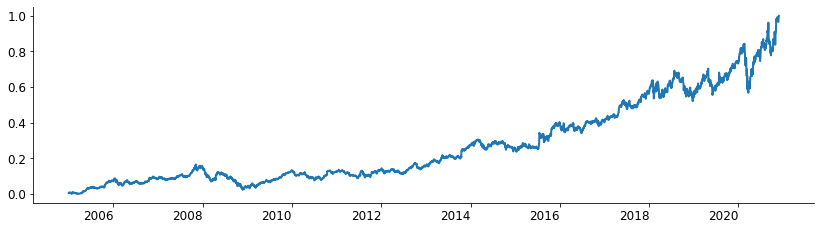

In [14]:
import seaborn as sns
ax = goog_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [15]:
# 훈련셋, 검증셋, 테스트셋 나누기
# 훈련셋: 2019년까지의 데이터
# 검증 및 테스트셋: 2020년 데이터


X_train = X[:'2019'].values.reshape(-1, window_size, 1)
y_train = y[:'2019']

# # keep the year 2018 for validating
# X_valid = X['2019'].values.reshape(-1, window_size, 1)
# y_valid = y['2019']

# keep the last year for test
X_test = X['2020'].values.reshape(-1, window_size, 1)
y_test = y['2020']

In [16]:
n_obs, window_size, n_features = X_train.shape

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3713, 63, 1), (230, 63, 1), (3713,), (230,))

## 2. Forecasting 1-Step Ahead

### 2.1 LSTM

In [23]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

lstm.compile(loss="mse", optimizer="adam")
lstm_training = lstm.fit(X_train, y_train, epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
117/117 [==============================] - 4s 38ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 2/50
117/117 [==============================] - 3s 24ms/step - loss: 1.4706e-04 - val_loss: 0.0031
Epoch 3/50
117/117 [==============================] - 3s 24ms/step - loss: 1.4390e-04 - val_loss: 0.0027
Epoch 4/50
117/117 [==============================] - 3s 24ms/step - loss: 1.4551e-04 - val_loss: 0.0027
Epoch 5/50
117/117 [==============================] - 3s 23ms/step - loss: 1.3523e-04 - val_loss: 0.0022
Epoch 6/50
117/117 [==============================] - 3s 24ms/step - loss: 1.4122e-04 - val_loss: 0.0027
Epoch 7/50
117/117 [==============================] - 3s 24ms/step - loss: 1.4146e-04 - val_loss: 0.0021
Epoch 8/50
117/117 [==============================] - 3s 24ms/step - loss: 1.3153e-04 - val_loss: 0.0016
Epoch 9/50
117/117 [==============================] - 3s 24ms/step - loss: 1.3049e-04 - val_loss: 0.0016
Epoch 10/50
117/117 [==============================] - 3s 2

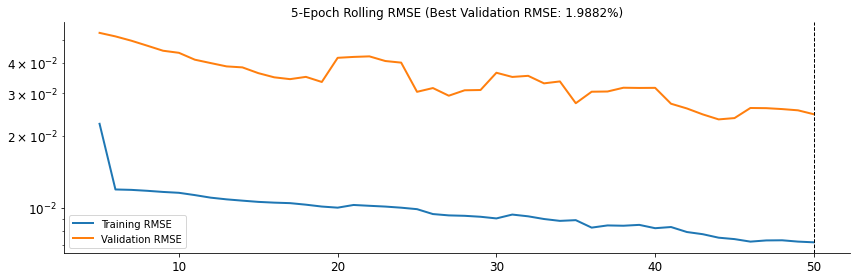

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
#fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [27]:
# Evaluation 

train_rmse_scaled = np.sqrt(lstm.evaluate(X_train, y_train, verbose=1))
test_rmse_scaled = np.sqrt(lstm.evaluate(X_test, y_test, verbose=1))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

from scipy.stats import spearmanr


train_predict_scaled = lstm.predict(X_train)
test_predict_scaled = lstm.predict(X_test)
print(train_predict_scaled.shape)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

# Rescale predictions

train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), index=y_test.index))

y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'



8/8 [==============================] - 0s 4ms/step - loss: 3.9531e-04
Train RMSE: 0.0068 | Test RMSE: 0.0199
(3713, 1)
Train IC: 0.9988 | Test IC: 0.9725


'Train RMSE: 11.69 | Test RMSE: 33.92'

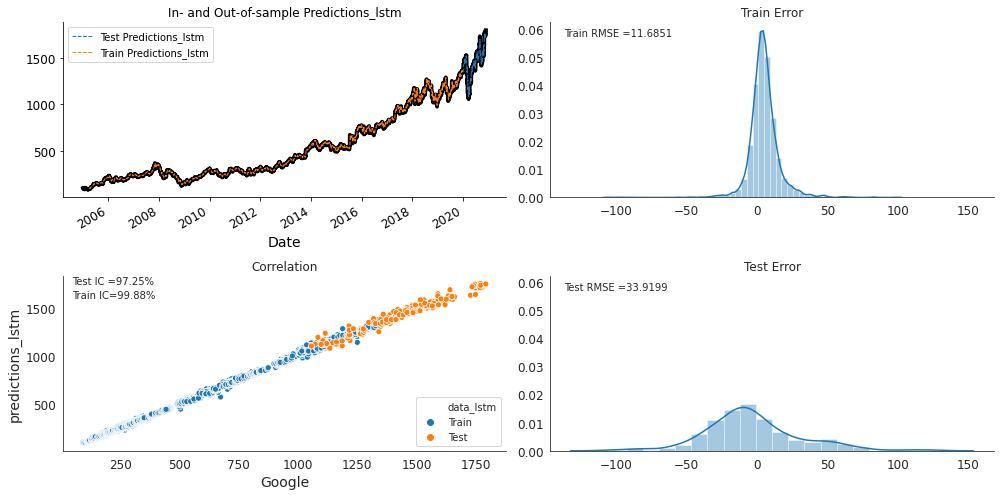

In [28]:
goog['Train Predictions_lstm'] = train_predict
goog['Test Predictions_lstm'] = test_predict
goog= goog.join(train_predict.to_frame('predictions_lstm').assign(data_lstm='Train')
                        .append(test_predict.to_frame('predictions_lstm').assign(data_lstm='Test')))

# Plot results

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

goog.loc['2005':, 'Google'].plot(lw=4, ax=ax1, c='k')
goog.loc['2005':, ['Test Predictions_lstm', 'Train Predictions_lstm']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions_lstm')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Google', y='predictions_lstm', data=goog, hue='data_lstm', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
#fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

### 2.2 GRU



In [32]:
gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20),
    keras.layers.Dense(1)
])

gru.compile(loss="mse", optimizer="adam")
gru_training = gru.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
117/117 [==============================] - 5s 39ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 2/20
117/117 [==============================] - 3s 30ms/step - loss: 6.9014e-05 - val_loss: 9.6131e-04
Epoch 3/20
117/117 [==============================] - 3s 29ms/step - loss: 6.3332e-05 - val_loss: 7.5911e-04
Epoch 4/20
117/117 [==============================] - 3s 29ms/step - loss: 5.8934e-05 - val_loss: 7.2068e-04
Epoch 5/20
117/117 [==============================] - 3s 29ms/step - loss: 5.4270e-05 - val_loss: 6.3899e-04
Epoch 6/20
117/117 [==============================] - 3s 28ms/step - loss: 5.3723e-05 - val_loss: 6.8317e-04
Epoch 7/20
117/117 [==============================] - 3s 28ms/step - loss: 4.8851e-05 - val_loss: 5.9590e-04
Epoch 8/20
117/117 [==============================] - 3s 28ms/step - loss: 4.6015e-05 - val_loss: 5.2017e-04
Epoch 9/20
117/117 [==============================] - 3s 28ms/step - loss: 4.3859e-05 - val_loss: 5.3545e-04
Epoch 10/20
117/117 [======

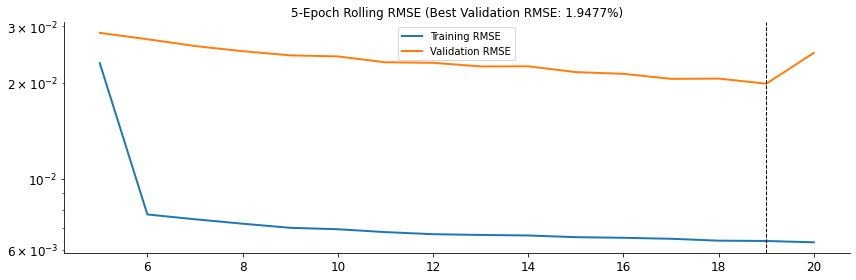

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(gru_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
#fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [34]:
# Evaluation 

train_rmse_scaled = np.sqrt(gru.evaluate(X_train, y_train, verbose=1))
test_rmse_scaled = np.sqrt(gru.evaluate(X_test, y_test, verbose=1))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

from scipy.stats import spearmanr


train_predict_scaled = gru.predict(X_train)
test_predict_scaled = gru.predict(X_test)
print(train_predict_scaled.shape)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

# Rescale predictions

train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), index=y_test.index))

y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

8/8 [==============================] - 0s 4ms/step - loss: 0.0020
Train RMSE: 0.0149 | Test RMSE: 0.0445
(3713, 1)
Train IC: 0.9991 | Test IC: 0.9719


'Train RMSE: 25.40 | Test RMSE: 75.87'

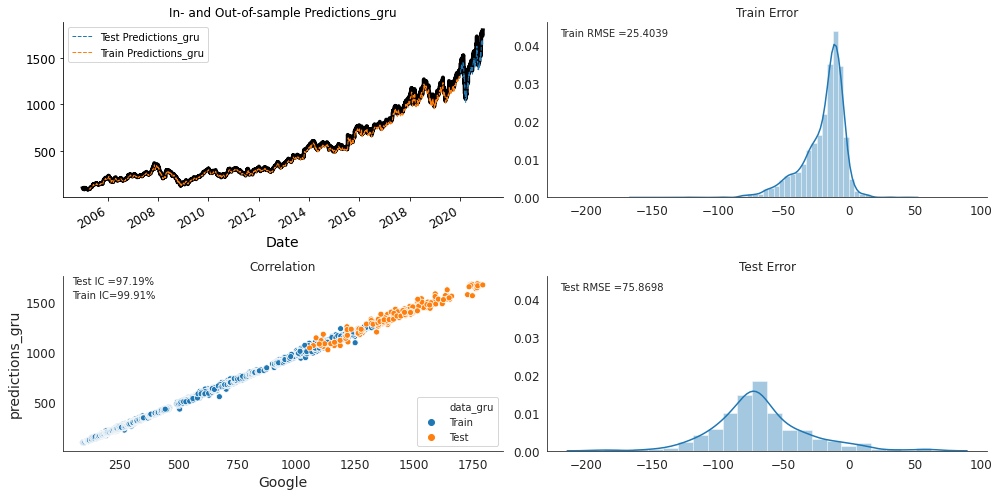

In [35]:
goog['Train Predictions_gru'] = train_predict
goog['Test Predictions_gru'] = test_predict
goog= goog.join(train_predict.to_frame('predictions_gru').assign(data_gru='Train')
                        .append(test_predict.to_frame('predictions_gru')
                                .assign(data_gru='Test')))

# Plot results

fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)

goog.loc['2005':, 'Google'].plot(lw=4, ax=ax1, c='k')
goog.loc['2005':, ['Test Predictions_gru', 'Train Predictions_gru']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions_gru')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Google', y='predictions_gru', data=goog, hue='data_gru', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
#fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

In [37]:
goog.tail()

,Google,Train Predictions_lstm,Test Predictions_lstm,predictions_lstm,data_lstm,Train Predictions_gru,Test Predictions_gru,predictions_gru,data_gru
Date,,,,,,,,,
2020-11-20,1742.189941,NaN,1735.850098,1735.850098,Test,NaN,1664.818115,1664.818115,Test
2020-11-23,1734.859985,NaN,1725.615845,1725.615845,Test,NaN,1652.319580,1652.319580,Test
2020-11-24,1768.880005,NaN,1716.935913,1716.935913,Test,NaN,1643.250000,1643.250000,Test
2020-11-25,1771.430054,NaN,1741.309814,1741.309814,Test,NaN,1662.462646,1662.462646,Test
2020-11-27,1793.189941,NaN,1754.383911,1754.383911,Test,NaN,1670.825317,1670.825317,Test
